In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns

url = 'insurance.csv'
df = pd.read_csv(url)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [2]:
#mapping certain variables to numerical values
df['sex']= df['sex'].map({'male':0,'female':1})
df['smoker']= df['smoker'].map({'yes':1,'no':0})

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520


0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64


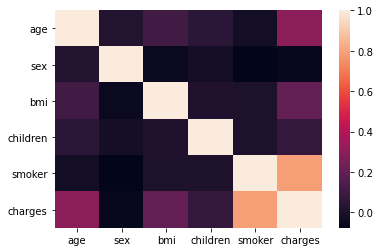

In [3]:
print(df.children.value_counts())
sns.heatmap(df.corr());

In [4]:
#changing the data type of the variables in our dataset to categorical 
categorical = set((
    'sex',
    'smoker',
    'region',
))
for name in categorical:
    df[name] = df[name].astype('category')
df.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

In [5]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [6]:
full_spans = get_spans(df, df.index)
full_spans

{'age': 46,
 'sex': 2,
 'bmi': 37.17,
 'children': 5,
 'smoker': 2,
 'region': 4,
 'charges': 62648.554110000005}

In [7]:
def split(df, partition, column): ## divides values by median 
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [60]:
def is_k_anonymous(df, partition, sensitive_column, k=4):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [61]:
# we apply our partitioning method to three columns of our dataset, using "charges" as the sensitive attribute
feature_columns = ['age', 'bmi', 'children']
sensitive_column = 'charges'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

# we get the number of partitions that were created
len(finished_partitions)

266

In [62]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [63]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [64]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [65]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column

    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break    
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
       
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        #values = grouped_columns.iloc[0].to_dict()   #ERROR HERE
        values = grouped_columns.iloc[0:3].to_dict()
        for i in values:
            conv_val = values[i]
            s = [str(integer) for integer in conv_val]
            a_string = "".join(s)
            res = round(float(a_string),2)
            values[i] = res
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...


In [66]:
feature_columns


['age', 'bmi', 'children']

In [67]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...


In [68]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
d2=dfn.sort_values(feature_columns+[sensitive_column])

In [69]:
d2

,age,bmi,children,charges,count
133,18.0,21.37,0.0,1607.51010,1
134,18.0,21.37,0.0,1702.45530,1
135,18.0,21.37,0.0,13747.87235,1
136,18.0,21.37,0.0,14283.45940,1
0,18.0,23.88,0.0,1121.87390,1
...,...,...,...,...,...
856,63.0,38.36,0.0,12981.34570,1
857,63.0,38.36,0.0,13470.80440,1
858,63.0,38.36,0.0,14210.53595,1
859,63.0,38.36,0.0,14410.93210,1


In [70]:
df.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [71]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,northwest,10600.54830
1334,18,1,31.920,0,0,northeast,2205.98080
1335,18,1,36.850,0,0,southeast,1629.83350
1336,21,1,25.800,0,0,southwest,2007.94500


In [72]:
dfn

,age,bmi,children,charges,count
0,18.00,23.88,0.0,1121.87390,1
1,18.00,23.88,0.0,1704.56810,1
2,18.00,23.88,0.0,1704.70015,1
3,18.00,23.88,0.0,1705.62450,1
4,18.00,23.88,0.0,2196.47320,1
...,...,...,...,...,...
1332,52.75,42.52,3.5,48549.17835,1
1333,61.25,40.25,3.0,12485.80090,1
1334,61.25,40.25,3.0,15170.06900,1
1335,61.25,40.25,3.0,15555.18875,1


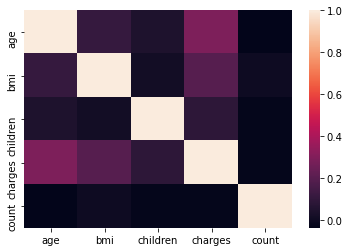

In [73]:
sns.heatmap(dfn.corr());

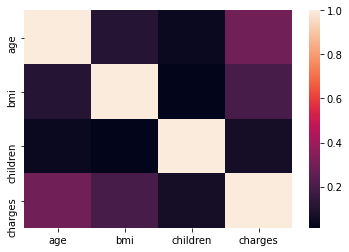

In [74]:
sns.heatmap(df.corr());